In [724]:
import os

from skimage import io, transform

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils

import math
import matplotlib.pyplot as plt

import random


In [725]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device}")

Using cuda


In [741]:
IMAGE_SIZE = 80 #Actual frames = 1440. must be divisible by 4
IMAGE_CHANNELS = 3
LATENT_VECTOR_SIZE = 100

Set the random seed:

In [727]:
torch.manual_seed(1337)

# Preparing training data

In [728]:
class VetleDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, sample_count, image_dir, transform=None):
        """
        Arguments:
            sample_count (int): How many samples
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sample_count = sample_count
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return self.sample_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        frameno = str(idx+1).zfill(4)
        filename = "frame" + frameno + ".png"

        img_name = os.path.join(self.image_dir,
                                filename)
        image = torchvision.io.read_image(img_name).float()
        

        if self.transform:
            image = self.transform(image)

        # Return image with a label. We won't use it, but it seems like tensorflow expects it
        return [image,0]

In [729]:
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.Normalize(128,128)])

In [730]:
dataset = VetleDataset(635, "assets/frames/", transform=transform)

Plot training data:

C:\Users\vmang\AppData\Local\Temp\ipykernel_15004\3385833128.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


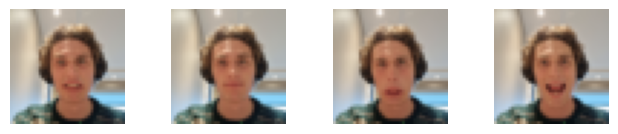

In [731]:
fig = plt.figure()
for plot_idx, dataset_idx  in enumerate(torch.randint(len(dataset), (4,))):
    sub = plt.subplot(1, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = dataset[dataset_idx.item()][0].permute(1,2,0)
    plt.imshow(image * 0.5 + 0.5)
fig.show()


Create data loader:

In [732]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


# The models


## Discriminator

In [733]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(IMAGE_SIZE**2*IMAGE_CHANNELS, 256),
            nn.ReLU(),
            
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), IMAGE_CHANNELS*IMAGE_SIZE**2)
        output = self.model(x)
        return output

In [734]:
discriminator = Discriminator()

## Generator

In [735]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcnn = nn.Sequential(
            nn.Linear(in_features=LATENT_VECTOR_SIZE, out_features=128*(IMAGE_SIZE//4)**2)
        )
        
        self.conv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        post_fcnn = self.fcnn(x)
        pre_cnn = post_fcnn.view(post_fcnn.size(0), 128, IMAGE_SIZE//4, IMAGE_SIZE//4)
        output = self.conv(pre_cnn)
        return output



In [736]:
generator = Generator()

# Training


## Hyperparameters

In [737]:
lr = 0.001
num_epochs = 20
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Loop

In [738]:
timeline = {
    "loss_discriminator":[],
    "loss_generator":[],
}
for epoch in range(num_epochs):
    print(epoch, end=" ")
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((real_samples.shape[0], 1))
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
        real_labels = torch.ones((batch_size, 1))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == len(train_loader) - 1:
            timeline["loss_discriminator"].append(loss_discriminator.detach())
            timeline["loss_generator"].append(loss_generator.detach())
            if epoch % 10 == 0:
                print("")
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")
           

0 
Epoch: 0 Loss D.: 0.6308916211128235
Epoch: 0 Loss G.: 2.6053669452667236
1 2 3 4 5 6 7 8 9 10 
Epoch: 10 Loss D.: 0.016591070219874382
Epoch: 10 Loss G.: 5.935756206512451
11 12 13 14 15 16 17 18 19 20 
Epoch: 20 Loss D.: 0.013484243303537369
Epoch: 20 Loss G.: 5.475399971008301
21 22 23 24 25 26 27 28 29 30 
Epoch: 30 Loss D.: 0.01958392933011055
Epoch: 30 Loss G.: 4.866114616394043
31 32 33 34 35 36 37 38 39 40 
Epoch: 40 Loss D.: 0.008826082572340965
Epoch: 40 Loss G.: 5.527135848999023
41 42 43 44 45 46 47 48 49 50 
Epoch: 50 Loss D.: 0.0069145034067332745
Epoch: 50 Loss G.: 5.000301361083984
51 52 53 54 55 56 57 58 59 60 
Epoch: 60 Loss D.: 0.010668321512639523
Epoch: 60 Loss G.: 4.737914085388184
61 62 63 64 65 66 67 68 69 70 
Epoch: 70 Loss D.: 0.005130305886268616
Epoch: 70 Loss G.: 5.565247535705566
71 72 73 74 75 76 77 78 79 80 
Epoch: 80 Loss D.: 0.0025970307178795338
Epoch: 80 Loss G.: 6.0097832679748535
81 82 83 84 85 86 87 88 89 90 
Epoch: 90 Loss D.: 0.00200348021462

# Results

C:\Users\vmang\AppData\Local\Temp\ipykernel_15004\582045452.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


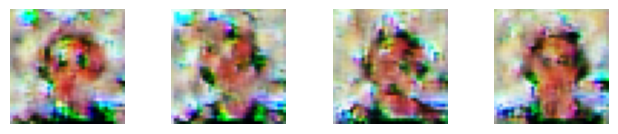

In [739]:
latent_space_samples = torch.randn((batch_size, LATENT_VECTOR_SIZE))
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
fig = plt.figure()
for plot_idx, dataset_idx  in enumerate(torch.randint(len(generated_samples), (4,))):
    sub = plt.subplot(1, 4, plot_idx+1)
    plt.tight_layout()
    sub.axis('off')
    image = generated_samples[dataset_idx.item()].permute(1,2,0)
    plt.imshow(image *0.5 + 0.5)
fig.show()


## Stats

C:\Users\vmang\AppData\Local\Temp\ipykernel_15004\3322973481.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  discriminator_plot.show()
C:\Users\vmang\AppData\Local\Temp\ipykernel_15004\3322973481.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  generator_plot.show()


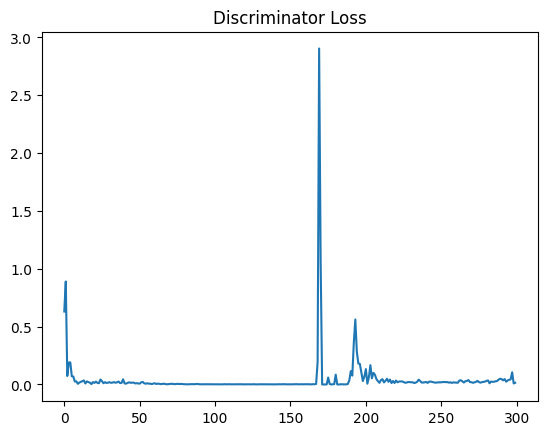

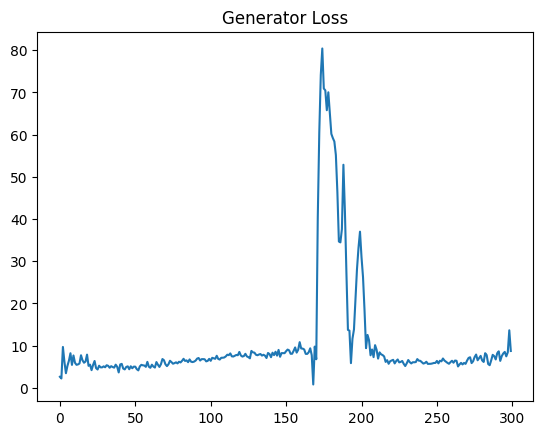

In [740]:
discriminator_plot = plt.figure()
plt.plot(range(0, num_epochs), timeline["loss_discriminator"])
plt.title("Discriminator Loss")
discriminator_plot.show()
generator_plot = plt.figure()
plt.plot(range(0, num_epochs), timeline["loss_generator"])
plt.title("Generator Loss")
generator_plot.show()